# Importing the libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

import keyring #handle secrets
import getpass

# import k-means from clustering stage
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

ModuleNotFoundError: No module named 'geocoder'

# Getting the data

The data is scraped from the wikipedia page:

https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

## Create BS object

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")

#print(soup.prettify()) # print the parsed data of html

## Scrape the data

In [3]:
table_contents=[] # list to save the data
table=soup.find('table')

for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        
table_contents[0:2]

[{'PostalCode': 'M3A', 'Borough': 'North York', 'Neighborhood': 'Parkwoods'},
 {'PostalCode': 'M4A',
  'Borough': 'North York',
  'Neighborhood': 'Victoria Village'}]

In [4]:
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
print(df.head())

  PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government


# Getting coordinates

The coordinates for every neighboorhood are gotten.

In [5]:
# Load aux file to get latitude and longitude
coords = pd.read_csv('data/Geospatial_Coordinates.csv')

In [6]:
def get_lat_long(postal_code):
    # initialize variable to None
    lat_lng_coords = None
    # tries 3 times to get the coordinates through geocoder.
    count = 0
    while(lat_lng_coords is None and count<=3):
        count+=1
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
        
    # if not, the aux file is used.
    if lat_lng_coords is None:
        # Get the row with the information
        row = coords[coords['Postal Code'] == postal_code]
        
        #Get the lat and long
        lat_lng_coords = (row['Latitude'].iat[0], row['Longitude'].iat[0])

    return lat_lng_coords

In [7]:
lat_longs = [get_lat_long(code) for code in df['PostalCode']]
df['latitude'] = [x[0] for x in lat_longs]
df['longitude'] = [x[1] for x in lat_longs]

In [8]:
df.head(5)

,PostalCode,Borough,Neighborhood,latitude,longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


## Cluster the neighborhoods

## Create a map with neighborhoods

In [9]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [10]:
# create map of New York using latitude and longitude values
toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['latitude'], df['longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto)  
    
toronto

# Get trending venues

Set information required to use the FourSquare API

In [11]:
# Use to set the secrets
# keyring.set_password('Foursquare_API', 'CLIENT_ID', getpass.getpass())
# keyring.set_password('Foursquare_API', 'CLIENT_SECRET', getpass.getpass())
CLIENT_ID = keyring.get_password("Foursquare_API", "CLIENT_ID")
CLIENT_SECRET = keyring.get_password("Foursquare_API", "CLIENT_SECRET")
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Define function to get nearby venues for each neighborhood

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[] # store the data
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    # Create dataframe from the list 
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Code to run the above function on each neighborhood and create a new dataframe.

In [13]:
toronto_venues = getNearbyVenues(df["Neighborhood"].values,
               df["latitude"].values,
               df["longitude"].values)

In [14]:
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Parkwoods,43.753259,-79.329656,GreenWin pool,43.756232,-79.333842,Pool
4,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
...,...,...,...,...,...,...,...
2118,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,McDonald's,43.630007,-79.518041,Fast Food Restaurant
2119,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Jim & Maria's No Frills,43.631152,-79.518617,Grocery Store
2120,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Islington Florist & Nursery,43.630156,-79.518718,Flower Shop
2121,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon


Use one hot encoding for the categories

In [15]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

Calculate the mean of each column grouping by Neighborhood. This is the percentage of venues of each category on each neighborhood.

In [16]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are 100 Neighborhoods and 272 categories.

In [17]:
toronto_grouped.shape

(100, 273)

## Top 10 venues for each neighborhood

Create a new dataframe with the top 10 venues for each neighborhood.

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Lounge,Breakfast Spot,Latin American Restaurant,Metro Station,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Gym,Sandwich Place,Pub,Coffee Shop,Mexican Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Intersection,Shopping Mall,Park,Middle Eastern Restaurant,Sandwich Place,Mobile Phone Shop,Fried Chicken Joint,Supermarket
3,Bayview Village,Japanese Restaurant,Bank,Chinese Restaurant,Café,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Accessories Store
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Toy / Game Store,Butcher,Café,Liquor Store,Restaurant,Juice Bar,Sushi Restaurant


# Cluster Neighborhoods

## Choose the number of clusters

<ipython-input-20-222ce6cef870>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  toronro_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)


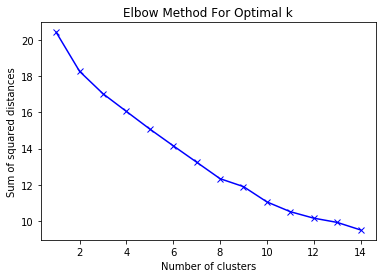

In [20]:
toronro_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

square_distances = []

for k in range(1,15):
    km = KMeans(n_clusters=k, n_init=100, random_state=0).fit(toronro_grouped_clustering)
    square_distances.append(km.inertia_)
    
plt.plot(range(1,15), square_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

8 clusters aregoing to be used.

## Fit the clusters

Run _k_-means to cluster the neighborhoods into 5 clusters.

In [21]:
# set number of clusters
kclusters = 8

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=200).fit(toronro_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

<ipython-input-21-e7d373df013d>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [22]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([86,  7,  1,  1,  1,  1,  2,  1]))

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [24]:
toronto_merge = df
toronto_merge = toronto_merge.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merge.head() # check the last columns!

,PostalCode,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Food & Drink Shop,Park,Fast Food Restaurant,Pool,Men's Store,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Metro Station
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Coffee Shop,Portuguese Restaurant,French Restaurant,Hockey Arena,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Pub,Bakery,Park,Breakfast Spot,Theater,Café,Chocolate Shop,Farmers Market,French Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Furniture / Home Store,Clothing Store,Accessories Store,Coffee Shop,Event Space,Athletics & Sports,Gift Shop,Boutique,Vietnamese Restaurant,Optical Shop
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,0.0,Coffee Shop,Sushi Restaurant,Café,College Cafeteria,Beer Bar,Spa,Smoothie Shop,Burrito Place,Sandwich Place,College Auditorium


## Examine clusters

In [25]:
def viz_cluster(cluster, ax):
    cl1 = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Labels'] == cluster, neighborhoods_venues_sorted.columns[[1] + list(range(5, neighborhoods_venues_sorted.shape[1]))]]

    cl1_largo = pd.melt(cl1, id_vars='Neighborhood')
    counts = cl1_largo.groupby('value').agg({'Neighborhood':'count'})
    counts.reset_index(inplace=True)
    df_1 = counts.nlargest(10, ['Neighborhood'], keep='first')
    df_1.sort_values('Neighborhood',ascending=True, inplace=True)

    # Create horizontal bars
    ax.barh('value', 'Neighborhood', data=df_1)
    ax.set_xlabel('Number of Neighborhoods')
    ax.set_title('Cluster {}'.format(cluster))

### Clusters description

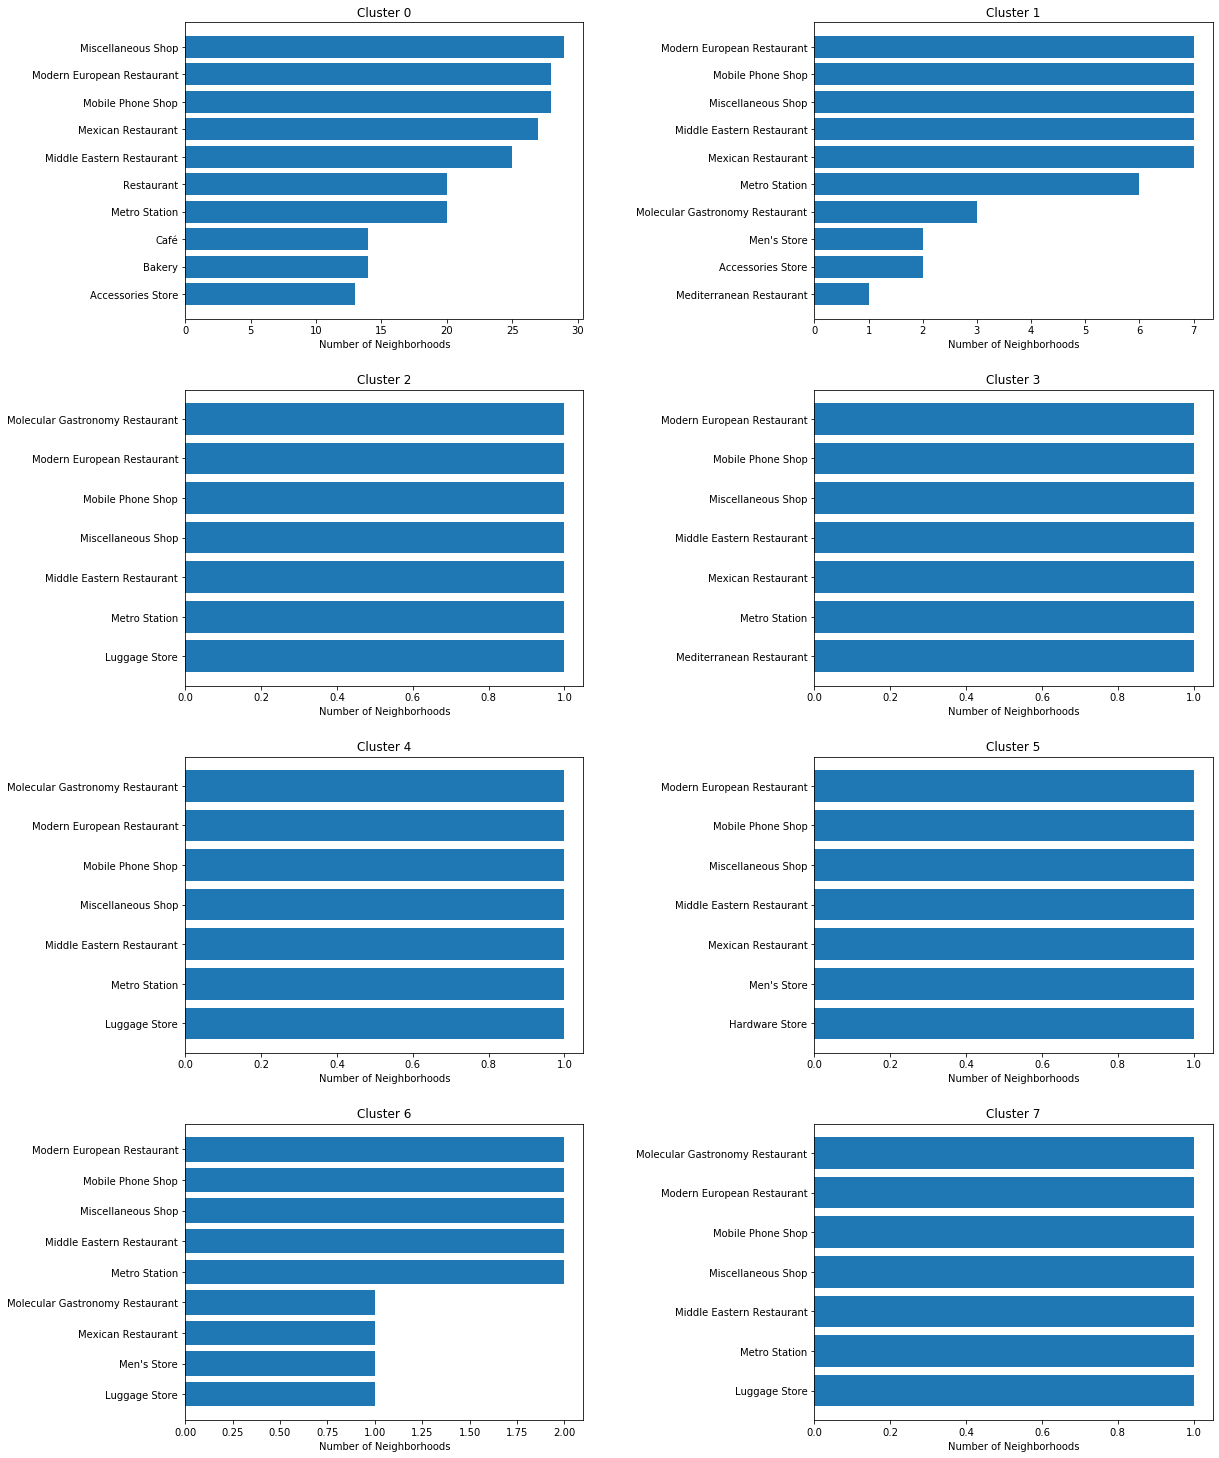

In [26]:
fig, axs = plt.subplots(4, 2)

fig.set_figheight(20)
fig.set_figwidth(15)
fig.tight_layout(h_pad=5, w_pad=20)

cluster=0
for i in range(4):
    for j in range(2):
        viz_cluster(cluster, axs[i, j])
        cluster+=1

Cluster 0 is the biggest one, but the neighborhoods are very similar and most of them have miscellaneous shops, modern European restaurants, mobile phone shops, Mexican restaurants, middle eastern restaurant, restaurants and metro stations.
The others, clusters are smaller, but they have different categories of venues like cluster 2, 4 and 7 with molecular gastronomy restaurants.

## Clusters Map

In [27]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
kclusters=8
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merge['latitude'],
                                  toronto_merge['longitude'],
                                  toronto_merge['Neighborhood'],
                                  toronto_merge['Cluster Labels']):
    if not np.isnan(cluster):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters